# Experiment 1. Recurrence and death risk prediction

## Import libriaries

In [1]:
# Uncomment the following lines if needed

#!pip install openpyxl
#!pip install matplotlib
#!pip install scikit-learn
#!pip install xgboost
#!pip install imblearn
#!pip install lifelines
#!pip install shap

In [2]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import utils  # Module with all hand-crafted methods

from sklearn.preprocessing import LabelEncoder
from sklearn.experimental import enable_iterative_imputer  # Required to enable IterativeImputer
from sklearn.impute import SimpleImputer, IterativeImputer

## Parameter definition

In [3]:
random_state = 42  # To enable reproducibility

nan_threshold = 600  # Number of NaN values to remove a column

imputer_iter = 10  # Number of iterations for the Iterative Imputer

## Read the dataset and filter columns

In [4]:
# Read dataset
duke = pd.read_excel(
    "../data/DUKE.xlsx",
    skiprows = [0,2],
    usecols = "A:CT"
)

# Columns with no relevant information for our purposes
unneeded_cols = ['Patient ID', 'Days to MRI', 'Manufacturer', 'Manufacturer Model Name',
                 'Scan Options', 'Field Strength (Tesla)', 'Patient Position During MRI',
                 'Contrast Agent', 'Contrast Bolus Volume (mL)', 'TR (Repetition Time)',
                 'TE (Echo Time)', 'Acquisition Matrix', 'Slice Thickness', 'Rows',
                 'Columns', 'Reconstruction Diameter', 'Flip Angle', 'Unnamed: 67',
                 'FOV Computed (Field of View) in cm', 'Definitive Surgery Type',
                 'Image Position of Patient', 'Position']

# Columns used later as labels in our models and the ones correlated to them
label_cols = ['Recurrence event(s)','Days to local recurrence', 'Days to distant recurrence', 
              'Days to death', 'Days to last local recurrence free assessment',
              'Days to last distant recurrence free assessment', 'Days known alive / to death']

# Store and remove the target columns while dropping the unnecessary ones
labels = duke[label_cols]
data = duke.drop(columns = unneeded_cols + label_cols)

# Print the shape of each DataFrame
print(duke.shape, data.shape, labels.shape)

(922, 98) (922, 69) (922, 7)


## Preprocessing data

We want to apply a classifier to predict recurrence and death risks. Hence, we need clean data, with missing values appropiately treated. First, we deal with $\textit{'No present'}$ and $\textit{'No conclusive'}$ values present in integer rows and remove the columns with more than 600 $NaN$ values out of all 922 instances.

In [5]:
# Print types of values of a int column containing strings
print(data['If Bilateral, Different Rec Status'].value_counts(), end="\n\n")

# Replace all instances of 'NC' and 'NP' with NaN
data.replace('NC', np.nan, inplace=True)
data.replace('NP', np.nan, inplace=True)

# Copy the data before preprocessing to assess baseline
baseline_data = data.copy()

# Convert Age column into years (currently days since birth as negative integers)
data['Age'] = np.abs(data['Age']) / 365.25

# Compute the number of NaN values
nan_counts = data.isna().sum()

# Identify columns to drop
nan_cols = nan_counts[nan_counts > nan_threshold].index

# Drop the identified columns
data = data.drop(columns=nan_cols)

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Convert categorical data into numerical dtypes
for column in data.select_dtypes(include=['object']).columns:
    data[column] = label_encoder.fit_transform(data[column])

If Bilateral, Different Rec Status
NP    623
NC    271
0      26
1       2
Name: count, dtype: int64



The next step is to deal with all $NaN$ values, as some models do not accept them. To do so, we need to treat each column independently and input data in the most harmless way we can.

In [6]:
# Store data with NaN values to see if our imputation helps
data_nan = data.copy()

# Enumerate the columns we want to fill with the mean
mean_cols = ['Tumor Grade (T)', 'Tumor Grade (N)', 'Tumor Grade (M)', 'Bilateral breast cancer?', 
             'Surgery', 'Days to Surgery', 'Neoadjuvant Radiation Therapy', 'Adjuvant Radiation Therapy', 
             'Neoadjuvant Chemotherapy', 'Adjuvant Chemotherapy', 'Neoadjuvant Endocrine Therapy Medications', 
             'Adjuvant Endocrine Therapy Medications', 'Neoadjuvant Anti-Her2 Neu Therapy', 
             'Adjuvant Anti-Her2 Neu Therapy', 'Received Neoadjuvant Therapy']

# Apply the imputer only to the columns we specified
data[mean_cols] = SimpleImputer(strategy='mean').fit_transform(data[mean_cols])

# Compute the sum of the three columns of Tumor Grade
grade_sum = data[['Tumor Grade (T)', 'Tumor Grade (N)', 'Tumor Grade (M)']].sum(axis=1)

# Define conditions for Nottingham grade
# Because of the previous imputation, we have to define intervals for each value
conditions = [
    (grade_sum >= 3) & (grade_sum < 5.5),
    (grade_sum >= 5.5) & (grade_sum < 7.5),
    (grade_sum >= 7.5) & (grade_sum <= 9)
]

# Fill values using the previous conditions to assign a value between 1 and 3
data['Nottingham grade'] = np.select(conditions, [1, 2, 3], default=data['Nottingham grade'])

# Enumerate the rest of imputed columns
it_cols = ['Staging (Tumor Size)', 'Staging (Nodes)', 'Histologic type']

# Apply the iterative imputer only to the columns we selected
data[it_cols] = IterativeImputer(max_iter=imputer_iter, random_state=random_state).fit_transform(data[it_cols])

We now create the target columns required for our experiment.

In [7]:
# Replace all instances of 'NP' with NaN
labels.replace('NP', np.nan, inplace=True)

# Define variables for these columns for easier reading
loc = labels['Days to local recurrence']
dis = labels['Days to distant recurrence']

# Define days to recurrence as the minimum between local and distant (not enough cases separately)
labels['Days to recurrence'] = np.where(np.isnan(loc), dis, np.where(np.isnan(dis), loc, np.minimum(loc, dis)))
labels.loc[:, 'Recurrence'] = np.where(labels['Days to recurrence'].notna(), 1, 0)

# Define Dead column to use it later in our experiment
labels.loc[:, 'Dead'] = np.where(labels['Days to death'].notna(), 1, 0)

# Replace NaN values by 0 for later prediction (NaNs not allowed)
labels.fillna(0, inplace=True)

## Assessing imputation performance

Once we have preprocessed our data, we check whether or not we performed a successful imputation by comparing $\textit{XGBoost}$ before and after filling $\textit{NaN}$ values.

In [8]:
# Store results
results = []

# Compute mean and std deviation for each test and combine them in a formatted string for better representation
results.append(['Recurrence (NaN)', *utils.get_formatted_metrics(utils.compute_metrics(utils.get_model("XGBoost"), data_nan, labels['Recurrence']))])
results.append(['Recurrence', *utils.get_formatted_metrics(utils.compute_metrics(utils.get_model("XGBoost"), data, labels['Recurrence']))])
results.append(['Dead (NaN)', *utils.get_formatted_metrics(utils.compute_metrics(utils.get_model("XGBoost"), data_nan, labels['Dead']))])
results.append(['Dead', *utils.get_formatted_metrics(utils.compute_metrics(utils.get_model("XGBoost"), data, labels['Dead']))])

pd.DataFrame(results, columns=["Test", "Accuracy", "Precision", "Recall", "F1-Score", "MCC"])

,Test,Accuracy,Precision,Recall,F1-Score,MCC
0,Recurrence (NaN),0.874 ± 0.009,0.139 ± 0.086,0.067 ± 0.054,0.088 ± 0.064,0.035 ± 0.061
1,Recurrence,0.890 ± 0.010,0.140 ± 0.196,0.022 ± 0.027,0.037 ± 0.046,0.021 ± 0.072
2,Dead (NaN),0.924 ± 0.018,0.450 ± 0.210,0.164 ± 0.107,0.219 ± 0.124,0.225 ± 0.132
3,Dead,0.926 ± 0.011,0.467 ± 0.287,0.097 ± 0.035,0.150 ± 0.039,0.173 ± 0.069


## Compute baseline

Now that we have processed data, we establish a baseline model for both prediction of $\textit{Recurrence}$ and $\textit{Dead}$, which will serve as an indicator of whether our preprocessing was successful or not and the performance of the models.

In [9]:
# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Convert categorical data into numerical dtypes
for column in baseline_data.select_dtypes(include=['object']).columns:
    baseline_data[column] = label_encoder.fit_transform(baseline_data[column])

# Compute baseline for both recurrence and death risk predictions
baseline_rec = utils.assess_baseline(baseline_data, labels['Recurrence'], True)
baseline_death = utils.assess_baseline(baseline_data, labels['Dead'], True)

## Target 1: Recurrence

#### Risk prediction

First, we compare 6 ML models with the baseline and see which one performs best through usual metrics ($\textbf{MCC}$ stands for $\textit{Matthews Correlation Coefficient}$).

In [10]:
recurrence_summary = pd.concat([baseline_rec, utils.compare_models(data, labels['Recurrence'])], axis=0, ignore_index=True)

recurrence_summary.head(7)

,Model,Accuracy,Precision,Recall,F1-Score,MCC
0,Baseline,0.889 ± 0.011,0.367 ± 0.323,0.056 ± 0.000,0.090 ± 0.009,0.091 ± 0.071
1,Logistic Regression,0.897 ± 0.011,0.200 ± 0.400,0.022 ± 0.044,0.040 ± 0.080,0.042 ± 0.139
2,Decision Tree,0.801 ± 0.018,0.097 ± 0.018,0.122 ± 0.022,0.108 ± 0.018,-0.002 ± 0.024
3,Random Forest,0.900 ± 0.003,0.200 ± 0.245,0.022 ± 0.027,0.040 ± 0.049,0.047 ± 0.078
4,XGBoost,0.890 ± 0.010,0.140 ± 0.196,0.022 ± 0.027,0.037 ± 0.046,0.021 ± 0.072
5,SVM,0.901 ± 0.002,0.000 ± 0.000,0.000 ± 0.000,0.000 ± 0.000,-0.005 ± 0.010
6,K-Nearest Neighbors,0.899 ± 0.008,0.200 ± 0.400,0.011 ± 0.022,0.021 ± 0.042,0.032 ± 0.098


Next, we repeat the computation but balancing the dataset using $\textbf{SMOTE}$.

In [11]:
recurrence_smote_summary = pd.concat([baseline_rec, utils.compare_models(data, labels['Recurrence'], True)], axis=0, ignore_index=True)

recurrence_smote_summary.head(7)

,Model,Accuracy,Precision,Recall,F1-Score,MCC
0,Baseline,0.889 ± 0.011,0.367 ± 0.323,0.056 ± 0.000,0.090 ± 0.009,0.091 ± 0.071
1,Logistic Regression,0.674 ± 0.022,0.144 ± 0.023,0.478 ± 0.097,0.221 ± 0.038,0.109 ± 0.057
2,Decision Tree,0.280 ± 0.122,0.101 ± 0.020,0.778 ± 0.099,0.177 ± 0.031,-0.010 ± 0.112
3,Random Forest,0.378 ± 0.109,0.105 ± 0.012,0.700 ± 0.083,0.182 ± 0.019,0.018 ± 0.075
4,XGBoost,0.171 ± 0.047,0.103 ± 0.005,0.967 ± 0.044,0.186 ± 0.008,0.058 ± 0.041
5,SVM,0.830 ± 0.041,0.164 ± 0.061,0.156 ± 0.054,0.156 ± 0.056,0.065 ± 0.071
6,K-Nearest Neighbors,0.644 ± 0.041,0.116 ± 0.029,0.389 ± 0.070,0.178 ± 0.042,0.040 ± 0.067


#### Fairness assessment

Now that we have computed our predictions, we define the protected attributes of our data and compute metrics by groups $\textit{Privileged / Unprivileged}$ in order to trade-off between performance and fairness. Hence, we study the best performing models.

In [12]:
# Define age ranges
age_ranges = [18, 51, 100]  # Chosen based on literature, change it as needed
privileged = [0, 1]

# Create a new DataFrame to assess fairness (since we are adding a column)
data_fairness = data.copy()

# Create a new column with age categories
data_fairness['Age Group'] = pd.cut(data_fairness['Age'], bins=age_ranges, labels=privileged)

# Define protected attributes and privileged / unprivileged groups
protected = ['Age Group', 'Mol Subtype', 'Race and Ethnicity']
priv = [[1], [0], [1]]
unpriv = [[0], [i for i in range(1, 4)], [0] + [i for i in range(2, 9)]]

In [13]:
utils.fairness_study('Random Forest', data_fairness, labels['Recurrence'], protected, priv, unpriv)

,Attribute,Group,Accuracy,Precision,Recall,F1-Score,MCC
0,Age Group,Unprivileged,0.888 ± 0.027,0.100 ± 0.200,0.020 ± 0.040,0.033 ± 0.067,0.031 ± 0.076
1,Age Group,Privileged,0.912 ± 0.021,0.000 ± 0.000,0.000 ± 0.000,0.000 ± 0.000,-0.011 ± 0.014
2,Mol Subtype,Unprivileged,0.868 ± 0.022,0.100 ± 0.200,0.022 ± 0.044,0.036 ± 0.073,0.030 ± 0.080
3,Mol Subtype,Privileged,0.916 ± 0.015,0.000 ± 0.000,0.000 ± 0.000,0.000 ± 0.000,-0.011 ± 0.014
4,Race and Ethnicity,Unprivileged,0.860 ± 0.010,0.067 ± 0.133,0.033 ± 0.067,0.044 ± 0.089,0.023 ± 0.077
5,Race and Ethnicity,Privileged,0.916 ± 0.009,0.000 ± 0.000,0.000 ± 0.000,0.000 ± 0.000,-0.005 ± 0.010


In [14]:
utils.fairness_study('XGBoost', data_fairness, labels['Recurrence'], protected, priv, unpriv)

,Attribute,Group,Accuracy,Precision,Recall,F1-Score,MCC
0,Age Group,Unprivileged,0.880 ± 0.034,0.100 ± 0.200,0.020 ± 0.040,0.033 ± 0.067,0.009 ± 0.089
1,Age Group,Privileged,0.904 ± 0.013,0.200 ± 0.400,0.013 ± 0.027,0.025 ± 0.050,0.023 ± 0.111
2,Mol Subtype,Unprivileged,0.865 ± 0.026,0.067 ± 0.133,0.022 ± 0.044,0.033 ± 0.067,0.016 ± 0.057
3,Mol Subtype,Privileged,0.904 ± 0.018,0.100 ± 0.200,0.017 ± 0.033,0.029 ± 0.057,0.007 ± 0.085
4,Race and Ethnicity,Unprivileged,0.857 ± 0.017,0.100 ± 0.200,0.033 ± 0.067,0.050 ± 0.100,0.022 ± 0.114
5,Race and Ethnicity,Privileged,0.905 ± 0.019,0.200 ± 0.400,0.015 ± 0.031,0.029 ± 0.057,0.026 ± 0.121


In [15]:
utils.fairness_study('K-Nearest Neighbors', data_fairness, labels['Recurrence'], protected, priv, unpriv)

,Attribute,Group,Accuracy,Precision,Recall,F1-Score,MCC
0,Age Group,Unprivileged,0.883 ± 0.037,0.200 ± 0.400,0.017 ± 0.033,0.031 ± 0.062,0.031 ± 0.122
1,Age Group,Privileged,0.914 ± 0.021,0.000 ± 0.000,0.000 ± 0.000,0.000 ± 0.000,-0.005 ± 0.010
2,Mol Subtype,Unprivileged,0.862 ± 0.041,0.200 ± 0.400,0.020 ± 0.040,0.036 ± 0.073,0.037 ± 0.134
3,Mol Subtype,Privileged,0.916 ± 0.012,0.000 ± 0.000,0.000 ± 0.000,0.000 ± 0.000,-0.010 ± 0.012
4,Race and Ethnicity,Unprivileged,0.859 ± 0.033,0.000 ± 0.000,0.000 ± 0.000,0.000 ± 0.000,-0.019 ± 0.038
5,Race and Ethnicity,Privileged,0.914 ± 0.009,0.100 ± 0.200,0.018 ± 0.036,0.031 ± 0.062,0.027 ± 0.081


#### Interpretability

We plot SHAP values to rank features by relevance in our predictions. In the case of non-tree based models (such as $\textit{Logistic Regression}$), this computation is quite expensive. Hence, we only perform the plot for the best model.

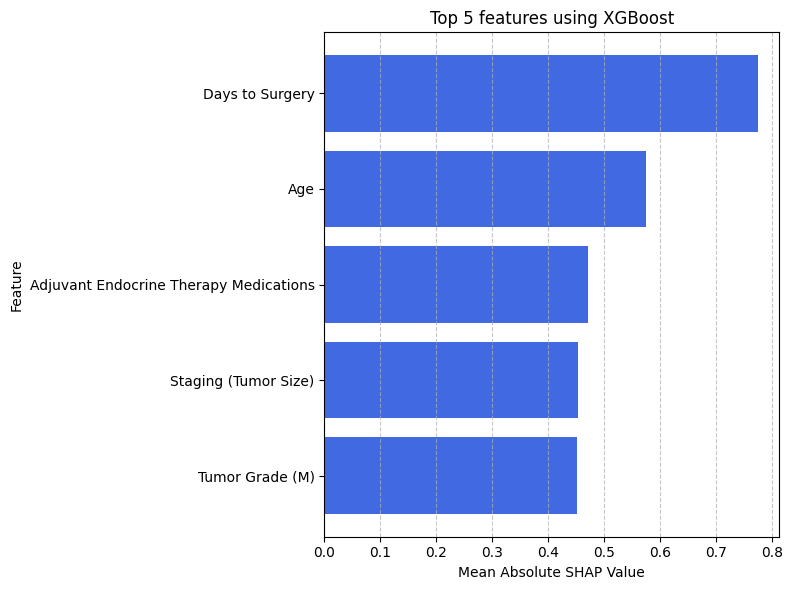

In [16]:
utils.top_features('XGBoost', data, labels['Recurrence'], top_n=5)

#### Survival time prediction

Finally, we predict the survival time before the event ocurrs (in this case, before the patient relapses).

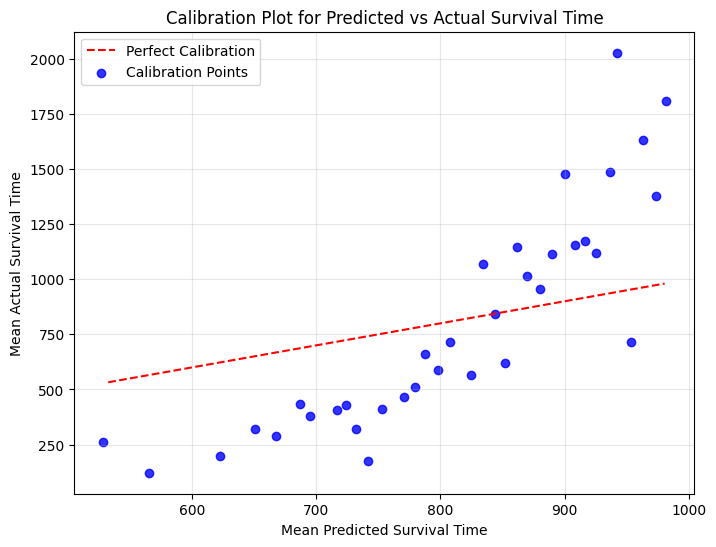

In [17]:
utils.predict_lifetime(data, labels, 'Days to recurrence', 'Recurrence', 50)

## Target 2: Death

We proceed in the same way as previously done for $\textit{Recurrence}$.

#### Risk prediction

In [18]:
death_summary = pd.concat([baseline_death, utils.compare_models(data, labels['Dead'])], axis=0, ignore_index=True)

death_summary.head(7)

,Model,Accuracy,Precision,Recall,F1-Score,MCC
0,Baseline,0.932 ± 0.011,0.557 ± 0.259,0.128 ± 0.037,0.202 ± 0.059,0.238 ± 0.096
1,Logistic Regression,0.935 ± 0.009,0.660 ± 0.280,0.163 ± 0.055,0.250 ± 0.084,0.292 ± 0.100
2,Decision Tree,0.905 ± 0.026,0.331 ± 0.151,0.308 ± 0.066,0.312 ± 0.098,0.266 ± 0.113
3,Random Forest,0.938 ± 0.003,0.733 ± 0.389,0.096 ± 0.060,0.166 ± 0.098,0.248 ± 0.130
4,XGBoost,0.926 ± 0.011,0.467 ± 0.287,0.097 ± 0.035,0.150 ± 0.039,0.173 ± 0.069
5,SVM,0.933 ± 0.002,0.000 ± 0.000,0.000 ± 0.000,0.000 ± 0.000,0.000 ± 0.000
6,K-Nearest Neighbors,0.936 ± 0.009,0.500 ± 0.447,0.082 ± 0.075,0.141 ± 0.128,0.190 ± 0.182


In [19]:
death_smote_summary = pd.concat([baseline_death, utils.compare_models(data, labels['Dead'], balance=True)], axis=0, ignore_index=True)

death_smote_summary.head(7)

,Model,Accuracy,Precision,Recall,F1-Score,MCC
0,Baseline,0.932 ± 0.011,0.557 ± 0.259,0.128 ± 0.037,0.202 ± 0.059,0.238 ± 0.096
1,Logistic Regression,0.761 ± 0.017,0.160 ± 0.029,0.595 ± 0.097,0.252 ± 0.044,0.213 ± 0.062
2,Decision Tree,0.357 ± 0.210,0.070 ± 0.016,0.660 ± 0.178,0.125 ± 0.027,-0.016 ± 0.092
3,Random Forest,0.595 ± 0.192,0.106 ± 0.018,0.614 ± 0.233,0.174 ± 0.025,0.116 ± 0.033
4,XGBoost,0.239 ± 0.125,0.074 ± 0.008,0.888 ± 0.109,0.137 ± 0.013,0.053 ± 0.057
5,SVM,0.899 ± 0.025,0.248 ± 0.106,0.192 ± 0.078,0.208 ± 0.075,0.162 ± 0.086
6,K-Nearest Neighbors,0.764 ± 0.014,0.149 ± 0.010,0.532 ± 0.031,0.233 ± 0.014,0.183 ± 0.020


#### Fairness assessment

In [20]:
utils.fairness_study('Logistic Regression', data_fairness, labels['Dead'], protected, priv, unpriv)

,Attribute,Group,Accuracy,Precision,Recall,F1-Score,MCC
0,Age Group,Unprivileged,0.948 ± 0.020,0.467 ± 0.400,0.233 ± 0.200,0.311 ± 0.267,0.319 ± 0.277
1,Age Group,Privileged,0.924 ± 0.010,0.500 ± 0.447,0.126 ± 0.112,0.189 ± 0.159,0.213 ± 0.207
2,Mol Subtype,Unprivileged,0.898 ± 0.025,0.633 ± 0.306,0.186 ± 0.046,0.268 ± 0.056,0.286 ± 0.088
3,Mol Subtype,Privileged,0.955 ± 0.006,0.500 ± 0.447,0.119 ± 0.109,0.189 ± 0.170,0.228 ± 0.210
4,Race and Ethnicity,Unprivileged,0.912 ± 0.031,0.500 ± 0.447,0.187 ± 0.165,0.256 ± 0.215,0.279 ± 0.234
5,Race and Ethnicity,Privileged,0.945 ± 0.013,0.547 ± 0.394,0.175 ± 0.121,0.245 ± 0.155,0.274 ± 0.187


In [21]:
utils.fairness_study('Decision Tree', data_fairness, labels['Dead'], protected, priv, unpriv)

,Attribute,Group,Accuracy,Precision,Recall,F1-Score,MCC
0,Age Group,Unprivileged,0.912 ± 0.015,0.205 ± 0.121,0.267 ± 0.200,0.219 ± 0.140,0.183 ± 0.146
1,Age Group,Privileged,0.877 ± 0.036,0.281 ± 0.133,0.278 ± 0.043,0.257 ± 0.057,0.206 ± 0.075
2,Mol Subtype,Unprivileged,0.870 ± 0.051,0.373 ± 0.131,0.330 ± 0.175,0.330 ± 0.112,0.272 ± 0.132
3,Mol Subtype,Privileged,0.905 ± 0.028,0.154 ± 0.121,0.159 ± 0.093,0.150 ± 0.102,0.104 ± 0.109
4,Race and Ethnicity,Unprivileged,0.875 ± 0.033,0.267 ± 0.154,0.306 ± 0.207,0.283 ± 0.175,0.219 ± 0.172
5,Race and Ethnicity,Privileged,0.901 ± 0.034,0.214 ± 0.148,0.222 ± 0.150,0.217 ± 0.148,0.165 ± 0.164


In [22]:
utils.fairness_study('Random Forest', data_fairness, labels['Dead'], protected, priv, unpriv)

,Attribute,Group,Accuracy,Precision,Recall,F1-Score,MCC
0,Age Group,Unprivileged,0.946 ± 0.015,0.400 ± 0.490,0.067 ± 0.082,0.114 ± 0.140,0.158 ± 0.194
1,Age Group,Privileged,0.930 ± 0.013,0.400 ± 0.490,0.077 ± 0.111,0.125 ± 0.174,0.159 ± 0.218
2,Mol Subtype,Unprivileged,0.908 ± 0.021,0.600 ± 0.490,0.087 ± 0.077,0.151 ± 0.131,0.216 ± 0.181
3,Mol Subtype,Privileged,0.953 ± 0.006,0.400 ± 0.490,0.057 ± 0.070,0.100 ± 0.122,0.144 ± 0.183
4,Race and Ethnicity,Unprivileged,0.912 ± 0.030,0.400 ± 0.490,0.100 ± 0.133,0.157 ± 0.204,0.191 ± 0.241
5,Race and Ethnicity,Privileged,0.948 ± 0.006,0.500 ± 0.447,0.084 ± 0.071,0.140 ± 0.116,0.193 ± 0.160


#### Interpretability

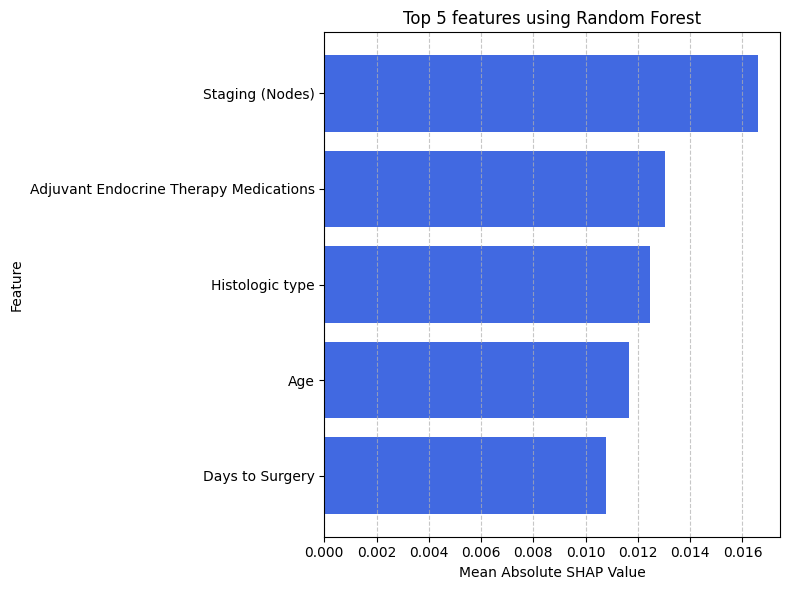

In [23]:
utils.top_features('Random Forest', data, labels['Dead'], 5)

#### Survival time prediction

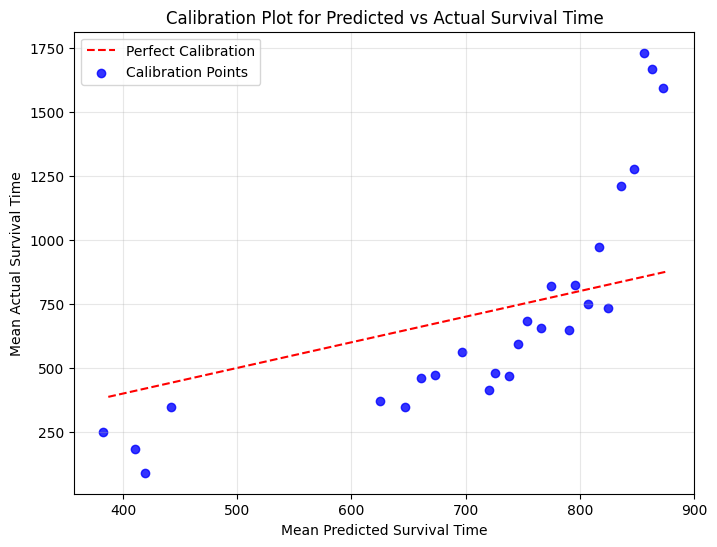

In [24]:
utils.predict_lifetime(data, labels, 'Days to death', 'Dead', 50)